In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np

import optuna

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [13]:
# Define image transformations (including normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load training and test data
full_train_data = datasets.MNIST(root=".\MNIST\MNIST_Train", train=True, download=False, transform = transform)
test_data = datasets.MNIST(root=".\MNIST\MNIST_Test", train=False, download=False, transform = transform)

# Set the seed for reproducibility
torch.manual_seed(42)  # You can choose any seed number

# Defining the sets that are going to be used for training and gridsearch
train_data = int(0.7 * len(full_train_data))  # 70% for training
train_gridsearch = len(full_train_data) - train_data # 30% for gridsearch
# Get the training and gridsearch sets
train_data, train_gridsearch = random_split(full_train_data, [train_data, train_gridsearch])

# Make the Training and Validation split of the train_gridsearch set
train_gridsearch2 = int(0.8 * len(train_gridsearch))  # 80% for training (gridsearch)
validation_gridsearch = len(train_gridsearch) - train_gridsearch2  # 20% for validation (gridsearch)
# Get the grid search sets
train_gridsearch2, validation_gridsearch = random_split(train_gridsearch, [train_gridsearch2, validation_gridsearch])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Number of images for total training:", len(full_train_data))
print("  |  Number of images for gridsearch:", len(train_gridsearch))
print("  |    |  Number of images for gridsearch training:", len(train_gridsearch2))
print("  |    |  Number of images for gridsearch validation:", len(validation_gridsearch))
print("  |  Number of images for training data after gridsearch:", len(train_data))
print("Number of images for testing:", len(test_data))

Number of images for total training: 60000
  |  Number of images for gridsearch: 18000
  |    |  Number of images for gridsearch training: 14400
  |    |  Number of images for gridsearch validation: 3600
  |  Number of images for training data after gridsearch: 42000
Number of images for testing: 10000


In [3]:
class CNN(nn.Module): # Encoder as we're only interested in the final embedding provided by the CNN 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(256 * 7 * 7, 128)  # Output: 128-dimension embeddings

        self.dropout2 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14
        
        x = self.dropout1(F.relu(self.conv3(x))) #Adding Drop out
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 7x7
        
        x = x.view(-1, 256 * 7 * 7)  # Flatten
        x = self.fc(x)  # Output embeddings
    
        x = self.dropout2(F.relu(self.fc1(x))) #Adding Drop out
        x = self.fc2(x)
        
        return x

In [4]:
class CNNModel(nn.Module):
    def __init__(self, encoder, optimizer, device='cpu'):
        super(CNNModel, self).__init__()
        self.encoder = encoder
        self.optimizer = optimizer
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = device  # Specify device to use (CPU or GPU)
        self.to(self.device)  # Ensure model is on the right device

    def forward(self, x):
        x = self.encoder(x)  # Pass through encoder to get the embeddings
        return x

    def train_step(self, x, y):
        """Performs one training step: forward pass, loss calculation, backpropagation, and optimization"""
        self.optimizer.zero_grad()  # Clear gradients
        x, y = x.to(self.device), y.to(self.device)  # Move data to the correct device
        output = self.forward(x)    # Forward pass
        loss = self.loss_fn(output, y)  # Calculate loss
        loss.backward()             # Backpropagation
        self.optimizer.step()       # Update the model parameters
        return loss.item()          # Return the loss value for monitoring

    def test_step(self, x, y):
        """Performs one testing step: forward pass and loss calculation"""
        with torch.no_grad():  # Disable gradient calculation for testing/evaluation
            x, y = x.to(self.device), y.to(self.device)  # Move data to the correct device
            output = self.forward(x)  # Forward pass
            loss = self.loss_fn(output, y)  # Calculate loss
            predicted = torch.argmax(output, dim=1)  # Get predicted class
            correct = (predicted == y).sum().item()  # Calculate the number of correct predictions
            total = y.size(0)  # Total number of samples
        return loss.item(), correct, total  # Return loss, correct predictions, and total samples

    def train_model(self, train_loader, epochs):
        """Train the model for a number of epochs"""
        self.train()  # Set model to training mode
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                x, y = batch
                loss = self.train_step(x, y)  # Perform training step
                total_loss += loss
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")  # Print average loss per epoch

    def test_model(self, test_loader, num_classes=10):
        self.encoder.eval()  # Set encoder to evaluation mode
        
        # Variables to store predictions and true labels for AUC/ROC/Confusion Matrix
        all_probs = []
        all_labels = []
        all_preds = []
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Get the model's raw logits output
                logits = self.encoder(images)
                
                # Convert logits to probabilities using softmax
                probs = F.softmax(logits, dim=1)
                
                # Record the true labels and predicted probabilities
                all_labels.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())
                
                # Get predicted class from the output (class with max probability)
                _, predicted = torch.max(logits, 1)
                all_preds.append(predicted.cpu().numpy())
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Flatten the collected lists
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        
        # Calculate test accuracy
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        
        # --- ROC and AUC computation ---
        # One-hot encode the labels
        labels_one_hot = np.eye(num_classes)[all_labels]

        # Compute ROC and AUC for each class
        roc_auc = {}
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_one_hot[:, i], all_probs[:, i])
            auc = roc_auc_score(labels_one_hot[:, i], all_probs[:, i])
            roc_auc[f'Class {i}'] = auc
            print(f'Class {i} AUC: {auc:.4f}')
            
            # Plot the ROC curve for each class
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        # Overall macro AUC score
        overall_auc = roc_auc_score(labels_one_hot, all_probs, average='macro')
        print(f'Overall AUC (macro): {overall_auc:.4f}')
        
        # --- Confusion Matrix ---
        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

In [5]:
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16)
    
    # Create data loaders
    train_loader = DataLoader(train_gridsearch2, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_gridsearch, batch_size=batch_size, shuffle=False)
    
    # Initialize encoder (CNN) and optimizer with the trial's hyperparameters
    encoder = CNN().to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()), lr=lr)
    
    # Create the model using CNNModel which includes the encoder and optimizer
    model = CNNModel(encoder, optimizer, device=device)
    
    # Train the model
    model.train_model(train_loader, epochs=10)  # Train the model
    
    # Evaluate on validation data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Perform forward pass through the model
            outputs = model(images)
            
            # Get predictions and calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation accuracy
    accuracy = correct / total
    return accuracy

In [6]:
model = CNN()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
           Dropout-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 256, 14, 14]         295,168
         MaxPool2d-7            [-1, 256, 7, 7]               0
            Linear-8                  [-1, 128]       1,605,760
            Linear-9                   [-1, 64]           8,256
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 2,002,506
Trainable params: 2,002,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [7]:
# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-10-22 18:55:56,150] A new study created in memory with name: no-name-a8da48f9-0e32-478b-a2c0-458f7540277c


Epoch 1/10, Loss: 1014.3003864015851
Epoch 2/10, Loss: 2.3069997787475587
Epoch 3/10, Loss: 2.32867819581713
Epoch 4/10, Loss: 2.3032159055982317
Epoch 5/10, Loss: 2.303510124342782
Epoch 6/10, Loss: 2.3032840354101998
Epoch 7/10, Loss: 2.303053971699306
Epoch 8/10, Loss: 2.3040023122515
Epoch 9/10, Loss: 2.3033251762390137
Epoch 10/10, Loss: 2.304041372026716


[I 2024-10-22 19:06:23,432] Trial 0 finished with value: 0.10777777777777778 and parameters: {'lr': 0.07891234691070226, 'batch_size': 208}. Best is trial 0 with value: 0.10777777777777778.


Epoch 1/10, Loss: 2.09073961575826
Epoch 2/10, Loss: 1.0593492239713669
Epoch 3/10, Loss: 0.6591726114352544
Epoch 4/10, Loss: 0.5403083011507988
Epoch 5/10, Loss: 0.46717776159445445
Epoch 6/10, Loss: 0.4182755569616953
Epoch 7/10, Loss: 0.3643916289011637
Epoch 8/10, Loss: 0.3487037075062593
Epoch 9/10, Loss: 0.3153495714068413
Epoch 10/10, Loss: 0.28398371463020644


[I 2024-10-22 19:17:21,430] Trial 1 finished with value: 0.9147222222222222 and parameters: {'lr': 3.219396376136845e-05, 'batch_size': 240}. Best is trial 1 with value: 0.9147222222222222.


Epoch 1/10, Loss: 1.1309689300755659
Epoch 2/10, Loss: 0.41462816052138807
Epoch 3/10, Loss: 0.2815811385711034
Epoch 4/10, Loss: 0.20669173076748848
Epoch 5/10, Loss: 0.16908455934996405
Epoch 6/10, Loss: 0.14304434072536726
Epoch 7/10, Loss: 0.12659669700699547
Epoch 8/10, Loss: 0.10980325234433015
Epoch 9/10, Loss: 0.10206694153447946
Epoch 10/10, Loss: 0.0916702527878806


[I 2024-10-22 19:30:17,989] Trial 2 finished with value: 0.9686111111111111 and parameters: {'lr': 4.042763250651428e-05, 'batch_size': 48}. Best is trial 2 with value: 0.9686111111111111.


Epoch 1/10, Loss: 2.594327983930129
Epoch 2/10, Loss: 2.301413569339486
Epoch 3/10, Loss: 2.3010528512703354
Epoch 4/10, Loss: 2.301155088483825
Epoch 5/10, Loss: 2.3011019821314846
Epoch 6/10, Loss: 2.3010491141977236
Epoch 7/10, Loss: 2.300912006880886
Epoch 8/10, Loss: 2.300946270772653
Epoch 9/10, Loss: 2.301095589186794
Epoch 10/10, Loss: 2.3010478481765864


[I 2024-10-22 19:40:23,171] Trial 3 finished with value: 0.10722222222222222 and parameters: {'lr': 0.0071385714210975585, 'batch_size': 112}. Best is trial 2 with value: 0.9686111111111111.


Epoch 1/10, Loss: 2.6463685152007312
Epoch 2/10, Loss: 2.3019888691785857
Epoch 3/10, Loss: 2.301586430247237
Epoch 4/10, Loss: 2.3015087261432554
Epoch 5/10, Loss: 2.301078424221132
Epoch 6/10, Loss: 2.3012362020771677
Epoch 7/10, Loss: 2.3012338295215513
Epoch 8/10, Loss: 2.3009419848279253
Epoch 9/10, Loss: 2.301196642038299
Epoch 10/10, Loss: 2.3011990378542646


[I 2024-10-22 19:50:38,437] Trial 4 finished with value: 0.10722222222222222 and parameters: {'lr': 0.010883219661759034, 'batch_size': 176}. Best is trial 2 with value: 0.9686111111111111.


Best hyperparameters:  {'lr': 4.042763250651428e-05, 'batch_size': 48}


Epoch 1/10, Loss: 0.6014319172501564
Epoch 2/10, Loss: 0.18751821456636703
Epoch 3/10, Loss: 0.12445057208623204
Epoch 4/10, Loss: 0.09709948399503317
Epoch 5/10, Loss: 0.08449288389485862
Epoch 6/10, Loss: 0.07299793891369231
Epoch 7/10, Loss: 0.06630232036486268
Epoch 8/10, Loss: 0.0586694697339886
Epoch 9/10, Loss: 0.05068922100814858
Epoch 10/10, Loss: 0.04587205433073853
Test Accuracy: 98.85%
Class 0 AUC: 1.0000
Class 1 AUC: 1.0000
Class 2 AUC: 0.9999
Class 3 AUC: 1.0000
Class 4 AUC: 1.0000
Class 5 AUC: 1.0000
Class 6 AUC: 0.9999
Class 7 AUC: 0.9999
Class 8 AUC: 0.9999
Class 9 AUC: 0.9999


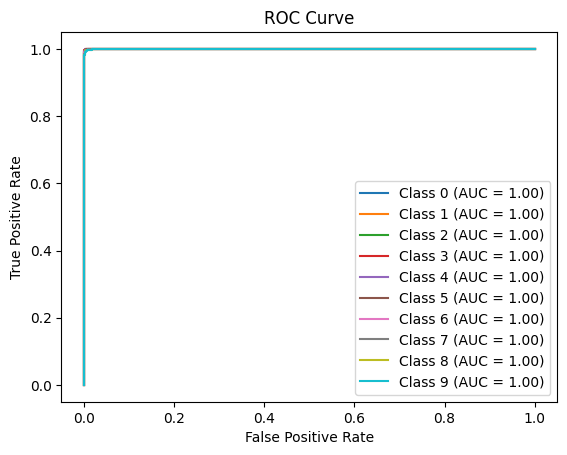

Overall AUC (macro): 0.9999


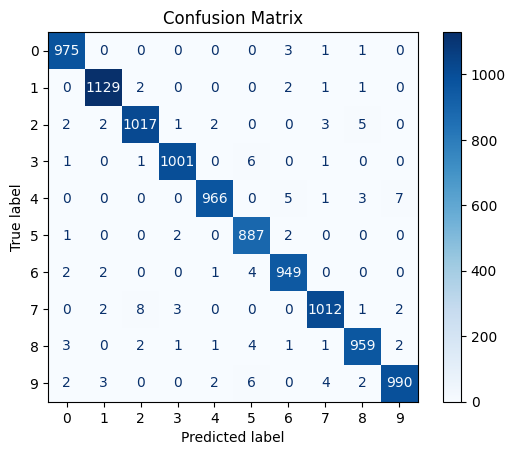

In [8]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_params

# Create data loaders with the best batch size
train_loader = DataLoader(train_data, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

# Initialize the CNN model (which includes both the encoder and the classifier)
encoder = CNN().to(device)

# Use Adam optimizer with the best learning rate
optimizer = torch.optim.Adam(list(encoder.parameters()), lr=best_params['lr'])

# Build the CNN model to be trained
trainer = CNNModel(encoder, optimizer, device=device)

# Final training using the best hyperparameters
trainer.train_model(train_loader, epochs=10)

# Final evaluation on the test set
trainer.test_model(test_loader)

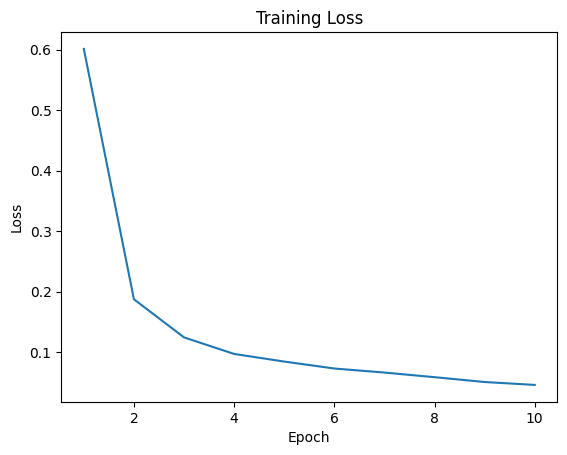

In [17]:
plt.plot([1,2,3,4,5,6,7,8,9,10], [0.6014319172501564,
                                  0.18751821456636703,
                                  0.12445057208623204,
                                  0.09709948399503317,
                                  0.08449288389485862,
                                  0.07299793891369231,
                                  0.06630232036486268,
                                  0.0586694697339886,
                                  0.05068922100814858,
                                  0.04587205433073853])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()